In [3]:
%matplotlib inline

import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, progress


In [129]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51637,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:51880,Total threads: 2
Dashboard: http://127.0.0.1:51890/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:51659,


# Problem 1

### Create SST Dataset

In [5]:
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url2 = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    
    file_list.append(single_file)


In [6]:
file_list

['https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_034_sstk.ll025sc.1979010100_1979120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1980/e5.moda.an.sfc.128_034_sstk.ll025sc.1980010100_1980120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1981/e5.moda.an.sfc.128_034_sstk.ll025sc.1981010100_1981120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1982/e5.moda.an.sfc.128_034_sstk.ll025sc.1982010100_1982120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1983/e5.moda.an.sfc.128_034_sstk.ll025sc.1983010100_1983120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1984/e5.moda.an.sfc.128_034_sstk.ll025sc.1984010100_1984120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1985/e5.moda.an.sfc.128_034_sstk.ll025sc.1985010100_1985120100.nc',
 'https://rda.ucar.edu/thre

In [7]:
ds = xr.open_mfdataset(file_list, chunks={'time': '100MB'}).sel(latitude=slice(65, -65, 1),longitude=slice(120, 300, 1)).compute()

In [8]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 521, longitude: 721, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 1979010100 1979020100 ... 2021110100 2021120100
    SSTK       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 07:46:57 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 07:46:58 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [9]:
gb = ds.SSTK.groupby('time.month')
gb

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [10]:
anom = gb - gb.mean(dim='time')

In [11]:
anom

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
array([[[            nan,             nan,             nan, ...,
         -8.17871094e-03, -1.33056641e-02, -1.83410645e-02],
        [            nan,             nan,             nan, ...,
         -1.33972168e-02, -2.06604004e-02, -2.74963379e-02],
        [            nan,             nan,             nan, ...,
         -1.77917480e-02, -2.50244141e-02, -3.21960449e-02],
        ...,
        [-3.00506592e-01, -3.01300049e-01, -3.02459717e-01, ...,
                     nan,             nan,             nan],
        [-8.54736328e-01, -8.40728760e-01, -8.27301025e-01, ...,
                     nan,             nan,             nan],
        [-8.32458496e-01, -8.32183838e-01, -8.46466064e-01, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -5.18798828e-04, -7.01904297e-04, -8.85009766e-04],
        [            nan,             nan,             nan, ...,
         -7.01904297e-04, -1.92260742e-03, -3.54003906e-03],
        [            nan,             nan,             nan, ...,
         -1.58691406e-03, -4.24194336e-03, -6.86645508e-03],
...
                     nan,             nan,             nan],
        [-6.92749023e-03, -8.08715820e-03, -9.15527344e-03, ...,
                     nan,             nan,             nan],
        [-8.54492188e-04, -1.40380859e-03, -1.40380859e-03, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
          9.37194824e-02,  6.34460449e-02,  3.24096680e-02],
        [            nan,             nan,             nan, ...,
          7.76062012e-02,  5.41687012e-02,  3.11279297e-02],
        [            nan,             nan,             nan, ...,
          7.62939453e-02,  5.80749512e-02,  4.01306152e-02],
        ...,
        [-1.10382080e-01, -8.47473145e-02, -6.00891113e-02, ...,
                     nan,             nan,             nan],
        [-3.03283691e-01, -2.89428711e-01, -2.75299072e-01, ...,
                     nan,             nan,             nan],
        [-1.43981934e-01, -1.37939453e-01, -1.40350342e-01, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

#### Mask data

In [16]:
mask_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
mask = xr.open_dataset(mask_url).sel(latitude=slice(65, -65, 1),longitude=slice(120, 300, 1)).compute()

In [31]:
mask_drop = mask.squeeze('time')
mask_time = mask_drop.expand_dims(time=anom.time)

In [62]:
mask_SST = anom.where(mask_time.LSM==0., np.nan)

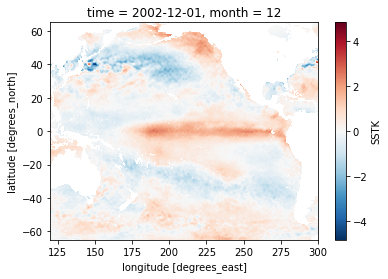

In [68]:
mask_SST.sel(time='2002-12-01', method='nearest').plot()

In [76]:
mask_SST

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
array([[[            nan,             nan,             nan, ...,
         -8.17871094e-03, -1.33056641e-02, -1.83410645e-02],
        [            nan,             nan,             nan, ...,
         -1.33972168e-02, -2.06604004e-02, -2.74963379e-02],
        [            nan,             nan,             nan, ...,
         -1.77917480e-02, -2.50244141e-02, -3.21960449e-02],
        ...,
        [-3.00506592e-01, -3.01300049e-01, -3.02459717e-01, ...,
                     nan,             nan,             nan],
        [-8.54736328e-01, -8.40728760e-01, -8.27301025e-01, ...,
                     nan,             nan,             nan],
        [-8.32458496e-01, -8.32183838e-01, -8.46466064e-01, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -5.18798828e-04, -7.01904297e-04, -8.85009766e-04],
        [            nan,             nan,             nan, ...,
         -7.01904297e-04, -1.92260742e-03, -3.54003906e-03],
        [            nan,             nan,             nan, ...,
         -1.58691406e-03, -4.24194336e-03, -6.86645508e-03],
...
                     nan,             nan,             nan],
        [-6.92749023e-03, -8.08715820e-03, -9.15527344e-03, ...,
                     nan,             nan,             nan],
        [-8.54492188e-04, -1.40380859e-03, -1.40380859e-03, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
          9.37194824e-02,  6.34460449e-02,  3.24096680e-02],
        [            nan,             nan,             nan, ...,
          7.76062012e-02,  5.41687012e-02,  3.11279297e-02],
        [            nan,             nan,             nan, ...,
          7.62939453e-02,  5.80749512e-02,  4.01306152e-02],
        ...,
        [-1.10382080e-01, -8.47473145e-02, -6.00891113e-02, ...,
                     nan,             nan,             nan],
        [-3.03283691e-01, -2.89428711e-01, -2.75299072e-01, ...,
                     nan,             nan,             nan],
        [-1.43981934e-01, -1.37939453e-01, -1.40350342e-01, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

### Create Precip Dataset

In [89]:
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
base_url2 = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    
    file_list.append(single_file)

In [90]:
file_list

['https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1979/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1979010100_1979120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1980/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1980010100_1980120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1981/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1981010100_1981120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1982/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1982010100_1982120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1983/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1983010100_1983120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1984/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1984010100_1984120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1985/e5.moda.fc.

In [91]:
ds_p = xr.open_mfdataset(file_list, chunks={'time': '100MB'}).sel(latitude=slice(65, -65, 1),longitude=slice(120, 300, 1)).compute()

In [92]:
ds_p

<xarray.Dataset>
Dimensions:    (latitude: 521, longitude: 721, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 1979010100 1979020100 ... 2021110100 2021120100
    TP         (time, latitude, longitude) float32 0.0002079 ... 0.0007496
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 08:45:33 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 08:45:34 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [94]:
group_p = ds_p.TP.groupby('time.month')
group_p

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [95]:
precip_anom = group_p - group_p.mean(dim='time')

In [96]:
precip_anom

<xarray.DataArray 'TP' (time: 516, latitude: 521, longitude: 721)>
array([[[-1.5105758e-04, -1.4256322e-04, -1.3364747e-04, ...,
          1.4146538e-03,  1.3548607e-03,  1.2932711e-03],
        [-1.6753617e-04, -1.6219117e-04, -1.5434000e-04, ...,
          1.2891237e-03,  1.2950897e-03,  1.3049148e-03],
        [-1.7917989e-04, -1.7944601e-04, -1.8002267e-04, ...,
          1.1772333e-03,  1.1944881e-03,  1.2119426e-03],
        ...,
        [-8.8500977e-04, -8.7853370e-04, -8.7223493e-04, ...,
         -1.6561775e-03, -1.7499479e-03, -1.8333390e-03],
        [-8.6686772e-04, -8.5289532e-04, -8.3721511e-04, ...,
         -1.5539790e-03, -1.3889268e-03, -1.2241408e-03],
        [-7.2756479e-04, -7.0964464e-04, -6.9019408e-04, ...,
         -1.1482239e-03, -1.0370432e-03, -8.9820591e-04]],

       [[ 1.3395798e-04,  1.3455679e-04,  1.3537740e-04, ...,
          1.9991009e-03,  2.0877705e-03,  2.1731132e-03],
        [ 1.0836401e-04,  1.0878540e-04,  1.1093673e-04, ...,
          2.2057821e-03,  2.3874238e-03,  2.5889596e-03],
        [ 1.0182138e-04,  1.0060155e-04,  9.7784883e-05, ...,
          2.5264830e-03,  2.7894531e-03,  3.0510039e-03],
...
        [-6.1665021e-04, -6.3119933e-04, -6.4776663e-04, ...,
          2.3709675e-03,  1.9019148e-03,  1.4396047e-03],
        [-7.0126110e-04, -7.1410241e-04, -7.2694384e-04, ...,
          7.8332145e-04,  6.2915892e-04,  4.7280069e-04],
        [-7.1754016e-04, -7.2984921e-04, -7.4371067e-04, ...,
          1.4719856e-04,  8.5897278e-05, -2.3109955e-05]],

       [[-2.1998826e-04, -2.2391387e-04, -2.2790598e-04, ...,
          1.2422828e-03,  1.2700058e-03,  1.2982835e-03],
        [-2.2165166e-04, -2.2788381e-04, -2.3183157e-04, ...,
          1.2917408e-03,  1.2979507e-03,  1.3027635e-03],
        [-2.1765952e-04, -2.2843826e-04, -2.3937225e-04, ...,
          1.2558338e-03,  1.2549910e-03,  1.2540817e-03],
        ...,
        [ 3.6641059e-04,  3.0883518e-04,  2.5068328e-04, ...,
          1.3539956e-03,  4.6685687e-04, -3.9817020e-04],
        [ 1.8008915e-04,  1.1082587e-04,  4.1229767e-05, ...,
         -5.0688908e-04, -5.9498195e-04, -6.8340742e-04],
        [-3.6195270e-05, -1.0162173e-04, -1.6141497e-04, ...,
         -7.7150029e-04, -7.0188206e-04, -7.1501173e-04]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

#### Masked Data

In [97]:
mask_precip = precip_anom.where(mask_time.LSM==0., np.nan)

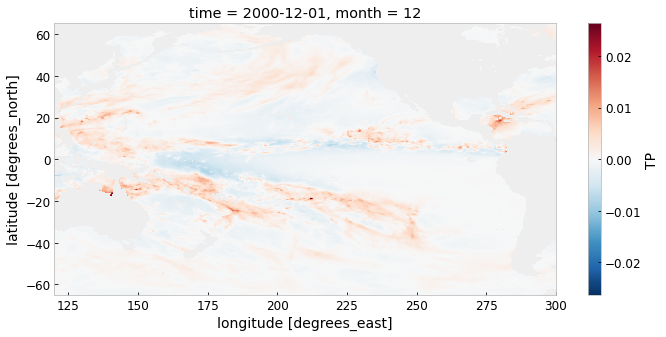

In [111]:
mask_precip.sel(time='2000-12-01', method='nearest').plot(size=5)

In [99]:
mask_precip

<xarray.DataArray 'TP' (time: 516, latitude: 521, longitude: 721)>
array([[[           nan,            nan,            nan, ...,
          1.4146538e-03,  1.3548607e-03,  1.2932711e-03],
        [           nan,            nan,            nan, ...,
          1.2891237e-03,  1.2950897e-03,  1.3049148e-03],
        [           nan,            nan,            nan, ...,
          1.1772333e-03,  1.1944881e-03,  1.2119426e-03],
        ...,
        [-8.8500977e-04, -8.7853370e-04, -8.7223493e-04, ...,
                    nan,            nan,            nan],
        [-8.6686772e-04, -8.5289532e-04, -8.3721511e-04, ...,
                    nan,            nan,            nan],
        [-7.2756479e-04, -7.0964464e-04, -6.9019408e-04, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
          1.9991009e-03,  2.0877705e-03,  2.1731132e-03],
        [           nan,            nan,            nan, ...,
          2.2057821e-03,  2.3874238e-03,  2.5889596e-03],
        [           nan,            nan,            nan, ...,
          2.5264830e-03,  2.7894531e-03,  3.0510039e-03],
...
        [-6.1665021e-04, -6.3119933e-04, -6.4776663e-04, ...,
                    nan,            nan,            nan],
        [-7.0126110e-04, -7.1410241e-04, -7.2694384e-04, ...,
                    nan,            nan,            nan],
        [-7.1754016e-04, -7.2984921e-04, -7.4371067e-04, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
          1.2422828e-03,  1.2700058e-03,  1.2982835e-03],
        [           nan,            nan,            nan, ...,
          1.2917408e-03,  1.2979507e-03,  1.3027635e-03],
        [           nan,            nan,            nan, ...,
          1.2558338e-03,  1.2549910e-03,  1.2540817e-03],
        ...,
        [ 3.6641059e-04,  3.0883518e-04,  2.5068328e-04, ...,
                    nan,            nan,            nan],
        [ 1.8008915e-04,  1.1082587e-04,  4.1229767e-05, ...,
                    nan,            nan,            nan],
        [-3.6195270e-05, -1.0162173e-04, -1.6141497e-04, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [112]:
anomalies = xr.DataArray()


# Problem 2

In [70]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.9.1


### Deseasonalize

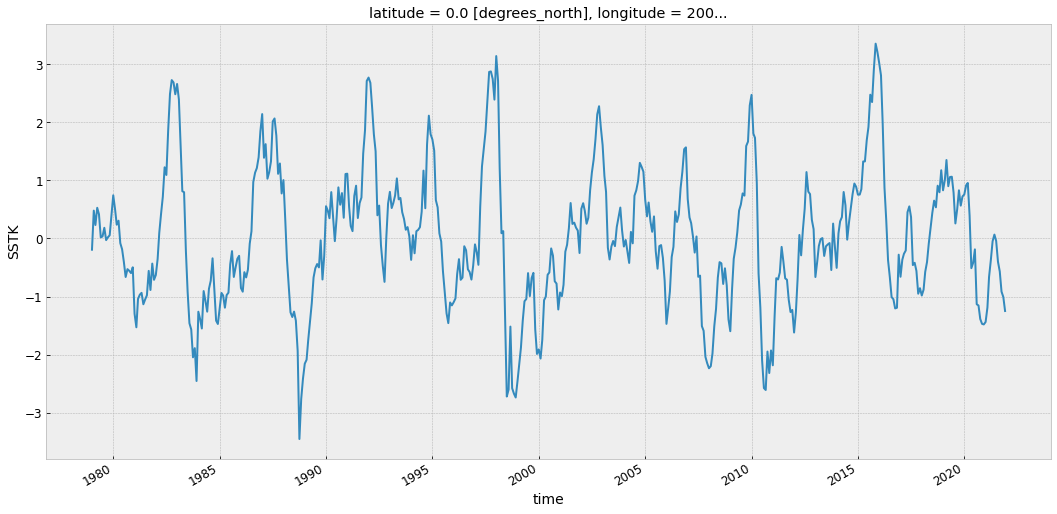

In [75]:
mask_SST.sel(latitude=0, longitude=200).plot()

#### Idea 1

In [130]:
#deseason = mask_SST.resample(time='AS').mean(dim='time') - mask_SST 

In [135]:
deseason = mask_SST.groupby('time.year').mean(dim='time') - mask_SST.groupby('time.year')

In [136]:
deseason

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
array([[[        nan,         nan,         nan, ..., -0.22597758,
         -0.23269399, -0.23998007],
        [        nan,         nan,         nan, ..., -0.25298563,
         -0.24157462, -0.22884879],
        [        nan,         nan,         nan, ..., -0.27283478,
         -0.2546107 , -0.23645273],
        ...,
        [ 0.13474019,  0.13316345,  0.13195038, ...,         nan,
                 nan,         nan],
        [ 0.6803233 ,  0.6690267 ,  0.65843964, ...,         nan,
                 nan,         nan],
        [ 0.6460063 ,  0.64825696,  0.6645686 , ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.2336375 ,
         -0.24529774, -0.25743613],
        [        nan,         nan,         nan, ..., -0.26568094,
         -0.2603124 , -0.25280508],
        [        nan,         nan,         nan, ..., -0.2890396 ,
         -0.27539316, -0.26178232],
...
        [-0.05154928, -0.03629049, -0.02094269, ...,         nan,
                 nan,         nan],
        [-0.01316833, -0.00148519,  0.0102361 , ...,         nan,
                 nan,         nan],
        [ 0.08842977,  0.09703827,  0.10281118, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.42792255,
          0.41046396,  0.39345297],
        [        nan,         nan,         nan, ...,  0.42027283,
          0.4110743 ,  0.39776865],
        [        nan,         nan,         nan, ...,  0.42191824,
          0.39196524,  0.36189523],
        ...,
        [ 0.03936259,  0.02657573,  0.01476288, ...,         nan,
                 nan,         nan],
        [ 0.28318787,  0.27985635,  0.2763799 , ...,         nan,
                 nan,         nan],
        [ 0.23155722,  0.23357391,  0.24175772, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
    year       (time) int64 1979 1979 1979 1979 1979 ... 2021 2021 2021 2021
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

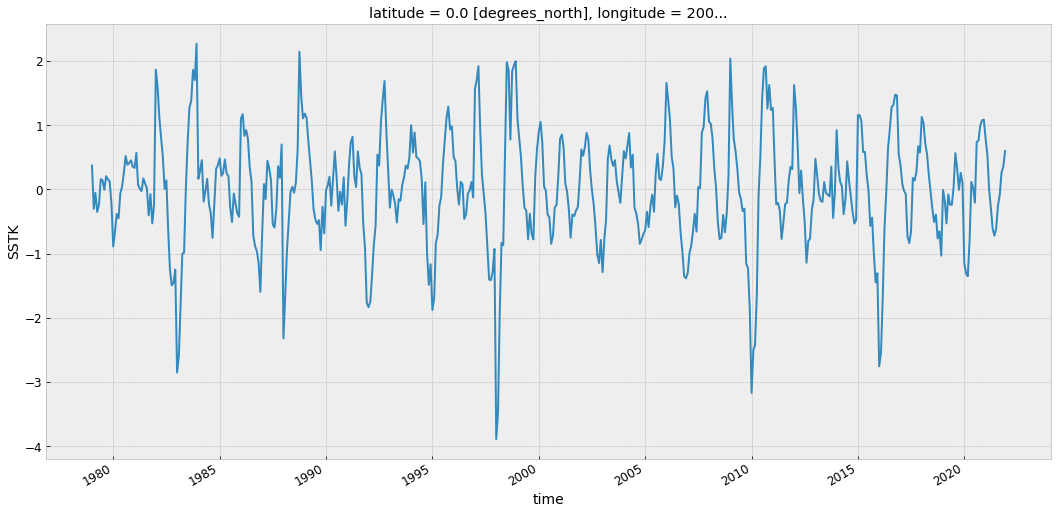

In [137]:
deseason.sel(latitude=0, longitude=200).plot()

#### Idea 2

In [142]:
data = mask_SST.sel(latitude=0, longitude=200)

In [143]:
data

<xarray.DataArray 'SSTK' (time: 516)>
array([-0.19342041,  0.48028564,  0.23242188,  0.5292053 ,  0.41778564,
        0.01815796,  0.03521729,  0.18460083, -0.02783203,  0.02032471,
        0.05545044,  0.39697266,  0.744812  ,  0.5059204 ,  0.23754883,
        0.30654907, -0.08026123, -0.18569946, -0.40179443, -0.664032  ,
       -0.52856445, -0.5560913 , -0.59664917, -0.4963379 , -1.2974243 ,
       -1.5307007 , -1.0422363 , -0.9690857 , -0.9369507 , -1.1339417 ,
       -1.0526733 , -0.97872925, -0.5583496 , -0.8876343 , -0.4328308 ,
       -0.7126465 , -0.630188  , -0.35272217,  0.09594727,  0.42642212,
        0.71881104,  1.2268982 ,  1.0950317 ,  1.8625793 ,  2.4890137 ,
        2.7302856 ,  2.6894836 ,  2.4858398 ,  2.6640015 ,  2.3970337 ,
        1.6467285 ,  0.81484985,  0.7974243 , -0.21182251, -0.9191284 ,
       -1.4604187 , -1.5693359 , -2.0480347 , -1.8905945 , -2.456543  ,
       -1.2625122 , -1.392273  , -1.5515137 , -0.90634155, -1.0724487 ,
       -1.2611389 , -0.8673706 , -0.7272644 , -0.34179688, -0.87420654,
       -1.4159851 , -1.473877  , -1.2109985 , -0.93865967, -0.9812012 ,
       -1.1927185 , -0.97528076, -0.9339905 , -0.44451904, -0.21798706,
       -0.6628418 , -0.5001831 , -0.34909058, -0.29907227, -0.8530884 ,
       -0.9171753 , -0.5805664 , -0.67123413, -0.53704834, -0.08950806,
        0.12408447,  0.9734192 ,  1.1345215 ,  1.2136841 ,  1.3999329 ,
        1.8479004 ,  2.1444702 ,  1.3914185 ,  1.6262207 ,  1.0299377 ,
...
       -0.5064087 ,  0.08843994,  0.29492188,  0.3692932 ,  0.80133057,
        0.5718689 , -0.0199585 ,  0.27859497,  0.5283203 ,  0.76275635,
        0.94729614,  0.89086914,  0.75531006,  0.75665283,  0.85009766,
        1.3277893 ,  1.328186  ,  1.6907654 ,  1.9229126 ,  2.4787903 ,
        2.3510742 ,  2.9075317 ,  3.3579407 ,  3.2175293 ,  3.0248413 ,
        2.8110962 ,  1.9858398 ,  0.8746643 ,  0.31573486, -0.3734436 ,
       -0.6605835 , -1.009491  , -1.0476074 , -1.2055054 , -1.1938171 ,
       -0.27929688, -0.659729  , -0.36590576, -0.26391602, -0.20687866,
        0.45343018,  0.5533142 ,  0.36773682, -0.45870972, -0.41918945,
       -0.5585327 , -0.9521179 , -0.85668945, -0.9829712 , -0.8822632 ,
       -0.5761719 , -0.40585327, -0.08953857,  0.1746521 ,  0.44171143,
        0.6526184 ,  0.5371094 ,  0.9102173 ,  0.7966614 ,  1.1765137 ,
        0.8307495 ,  1.005188  ,  1.3525391 ,  0.9015198 ,  1.0598755 ,
        1.0645447 ,  0.79034424,  0.25930786,  0.5046387 ,  0.8303833 ,
        0.5659485 ,  0.7246094 ,  0.7584839 ,  0.91534424,  0.9567871 ,
        0.39419556, -0.51190186, -0.41860962, -0.1876831 , -1.1332703 ,
       -1.1547852 , -1.3878784 , -1.4721375 , -1.4814453 , -1.4385376 ,
       -1.1896362 , -0.6628418 , -0.36898804, -0.04730225,  0.06698608,
       -0.04144287, -0.39987183, -0.56884766, -0.9154663 , -1.0092468 ,
       -1.25      ], dtype=float32)
Coordinates:
    latitude   float64 0.0
    longitude  float64 200.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [156]:
df = pd.DataFrame()
df['Date'] = data.time
df['SSTK'] = data.values
df = df.set_index('Date')
df

,SSTK
Date,
1979-01-01,-0.193420
1979-02-01,0.480286
1979-03-01,0.232422
1979-04-01,0.529205
1979-05-01,0.417786
...,...
2021-08-01,-0.399872
2021-09-01,-0.568848
2021-10-01,-0.915466


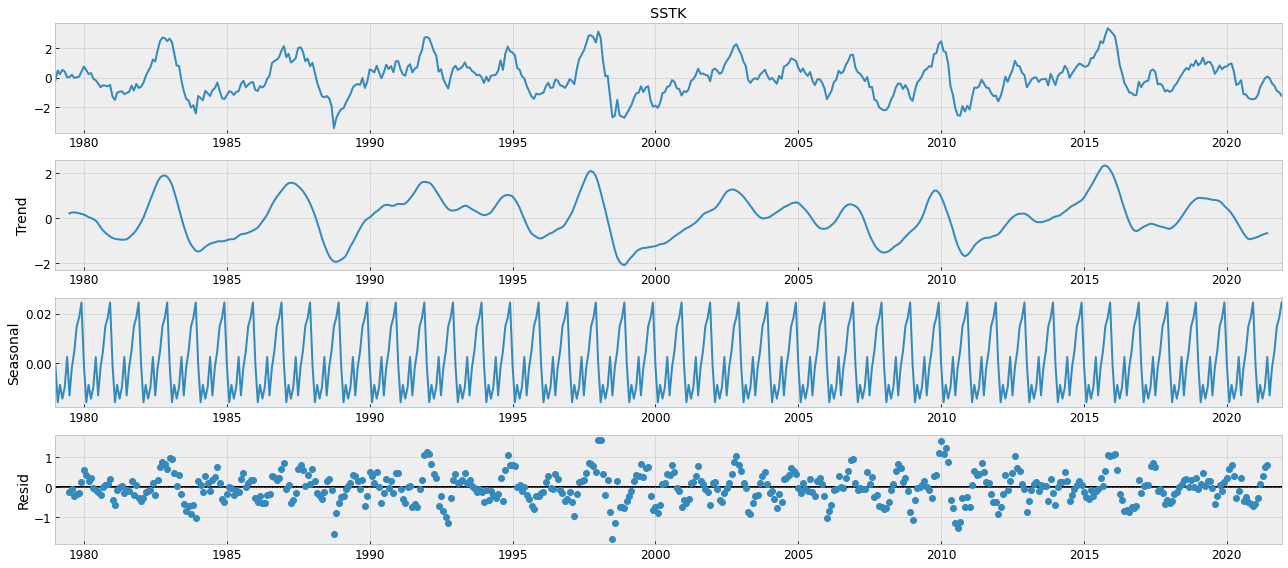

<Figure size 4000x1600 with 0 Axes>

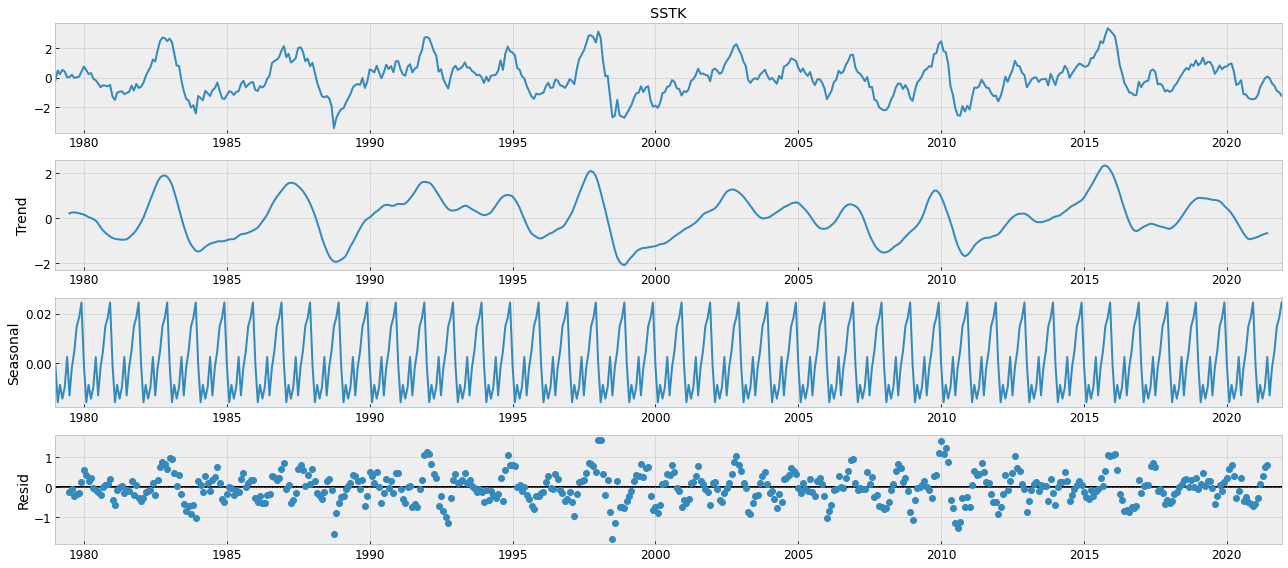

In [157]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.SSTK
result = seasonal_decompose(series, model='additive')
result.plot()

In [163]:
deseason2 = df.SSTK - result.seasonal
deseason2

Date
1979-01-01   -0.192872
1979-02-01    0.496280
1979-03-01    0.241338
1979-04-01    0.543729
1979-05-01    0.427679
                ...   
2021-08-01   -0.398059
2021-09-01   -0.573653
2021-10-01   -0.930250
2021-11-01   -1.027648
2021-12-01   -1.274533
Length: 516, dtype: float64

<AxesSubplot:xlabel='Date'>

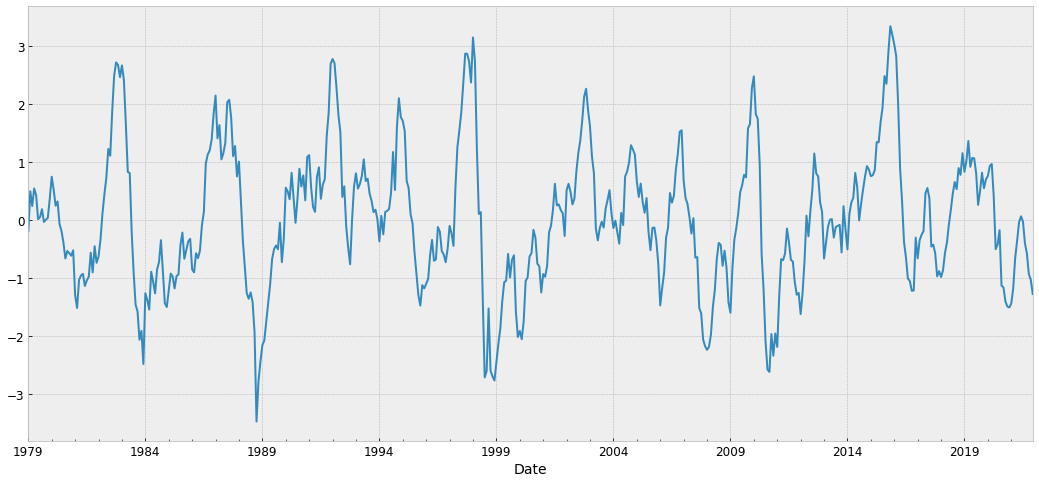

In [164]:
deseason2.plot()

### Detrend

Text(0.5, 1.0, 'Trend fitted by linear regression')

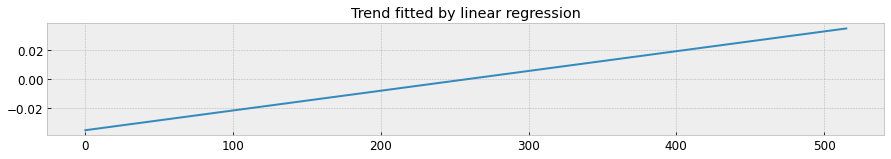

In [183]:
# Detrend using the second deseason method...
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

X = [i for i in range(0, len(deseason2))]
X = np.reshape(X, (len(X), 1))
y = deseason2.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

# test = deseason.sel(latitude=0, longitude=200)

# model = LinearRegression().fit(test, test.time)

In [185]:
# Detrend???

detrend = deseason2.subtract(trend)

<AxesSubplot:xlabel='Date'>

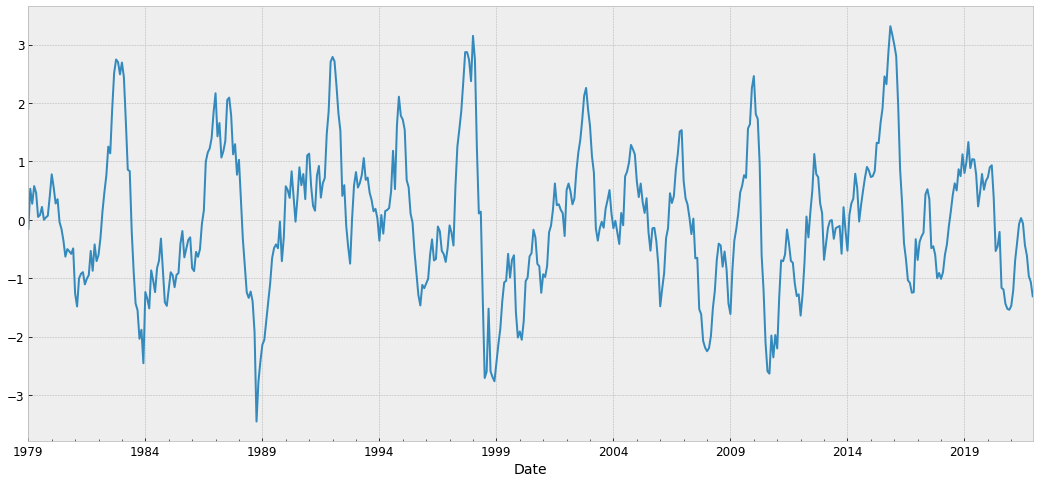

In [186]:
detrend.plot()

### Standardize

<AxesSubplot:xlabel='Date'>

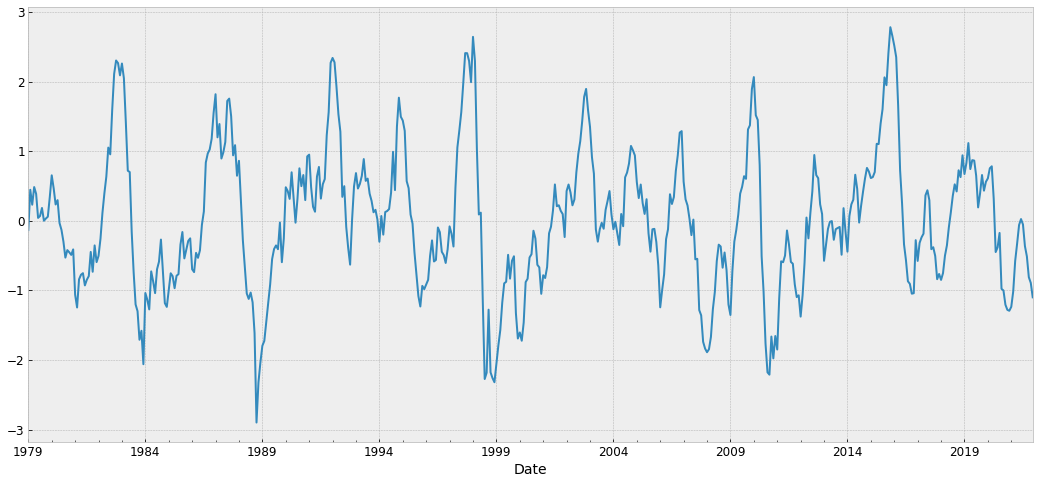

In [194]:
# Standardize????

long_mean = detrend.mean()
standard = detrend.std()

standardize = (detrend - long_mean)/standard
standardize.plot()

In [127]:
client.close()

2022-10-10 23:38:58,667 - distributed.nanny - WARNING - Worker process still alive after 3.999999237060547 seconds, killing
2022-10-10 23:38:58,834 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2022-10-10 23:38:58,853 - distributed.nanny - WARNING - Worker process still alive after 3.9999990463256836 seconds, killing
2022-10-10 23:38:58,900 - distributed.nanny - WARNING - Worker process still alive after 3.999999237060547 seconds, killing
Task was destroyed but it is pending!
task: <Task pending name='Task-1051' coro=<RequestHandler._execute() running at /Users/ecwolff3/opt/anaconda3/envs/py3/lib/python3.10/site-packages/tornado/web.py:1704> wait_for=<Task finished name='Task-1169814' coro=<WSHandler.on_message() done, defined at /Users/ecwolff3/opt/anaconda3/envs/py3/lib/python3.10/site-packages/bokeh/server/views/ws.py:225> result=None> cb=[_HandlerDelegate.execute.<locals>.<lambda>() at /Users/ecwolff3/opt/anaconda3/envs/py3/lib/python3.10/sit